In [1]:
import sys
import os

import pandas as pd
import numpy as np
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.optimize import linear_sum_assignment
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

from helper_funcs import eta_2_log_Gamma
from helper_funcs import eta0_2_log_delta
from helper_funcs import log_Gamma_2_eta
from helper_funcs import log_delta_2_eta0

np.random.seed(0)
random.seed(0)

In [2]:
#date = "Sep-25-2022" # both buffers
date = "Sept-21-2022_large"
#date = "Sep-21-2022" # Beth's case study
#date = "Sep-19-2022" # No buffer for mini-batches, no buffer for weights
#date = "Sep-15-2022" # Make a buffer for mini-batches, but not for weights
#date = "Sep-16-2022" # Make a buffer for weights, but not for mini-batches

param_folder = "/Volumes/One Touch/sublinear-HMM-inference/case_study/large"
#param_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/params/case_study/" + date
#plot_folder = "/Users/evsi8432/Documents/Research/sublinear-HMM-inference/plt/case_study/" + date

methods = ["control","BFGS","SAGA","SVRG","GD","CG"]
K = [3,3] #[3,4] #K = [2,3]
partial_Es = [0.0,0.5,1.0]

tol = 1e-3

optims = {}
times_to_converge = {}
epochs_to_converge = {}
lls = {}

#"experiment_1_2022-08-05_20-27-39"
#"experiment_1_2022-08-05_20-26-58"
#"experiment_1_2022-08-05_20-26-22"
#"experiment_1_2022-08-05_20-25-49"
#"experiment_1_2022-08-05_20-25-36"
#"experiment_1_2022-08-05_20-27-53"
#"experiment_1_2022-08-05_20-25-18"
#"experiment_1_2022-08-05_20-25-12"

#with open("../params/experiment_1_2022-08-05_20-25-49","rb") as f:
#    optims = pickle.load(f)
    

In [9]:
for method in methods:
    for partial_E in partial_Es:
        if method in ["BFGS","CG","GD","control"] and partial_E > 0.0:
            pass
        else:
            
            # get best ll
            best_ll = -np.infty
            best_fname = param_folder + "/case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)
            
            # initialize lls
            lls[(method,partial_E)] = []
            
            # initialize epochs
            epochs_to_converge[(method,partial_E)] = []
            
            # initialize times
            times_to_converge[(method,partial_E)] = []
            
            for rand_seed in range(100):
                
                fname = param_folder + "/case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,rand_seed)
                
                try:
                    with open(fname, 'rb') as f:
                        optim = pickle.load(f)
                    print("loaded file %s" % fname)
                except:
                    print("file %s does not exist" % fname)
                    continue
                
                # check for some issue (likely nan in theta)
                if len(optim.time_trace) == 0:
                    print("file %s didn't optimize." % fname)
                    continue
                    
                
                # get convergence ind
                converge_ind = min(np.where(np.array(optim.grad_norm_trace) < tol)[0],
                                   default=len(optim.grad_norm_trace)-1)
                
                epochs_to_converge[(method,partial_E)].append(optim.epoch_trace[converge_ind])
                times_to_converge[(method,partial_E)].append(optim.time_trace[converge_ind])
                lls[(method,partial_E)].append(optim.log_like_trace[converge_ind])
                
                if optim.log_like_trace[-1] > best_ll:    
                    optims[(method,partial_E)] = optim
                    best_fname = fname
                    best_ll = optim.log_like_trace[-1]
                    
            print(best_fname)

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_000
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_001
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_002
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_003
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_007
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_008
l

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_074
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_075
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_076
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_077
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_078
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_079
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_080
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_081
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_control_0.0_082
l

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_049
file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_049 didn't optimize.
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_050
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_051
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_052
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_053
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_054
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_055
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_BFGS_0.0_056
loaded file /Volum

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_023
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_024
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_025
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_026
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_027
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_028
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_029
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_030
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_031
loaded file /Volumes/One Tou

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_099
/Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.0_033
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_000
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_001
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_002
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_003
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_006
loaded file /Volumes/One Touch/sublinear

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_074
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_075
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_076
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_077
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_078
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_079
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_080
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_081
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_0.5_082
loaded file /Volumes/One Tou

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_049
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_050
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_051
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_052
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_053
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_054
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_055
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_056
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SAGA_1.0_057
loaded file /Volumes/One Tou

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_024
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_025
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_026
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_027
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_028
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_029
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_030
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_031
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.0_032
loaded file /Volumes/One Tou

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_000
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_001
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_002
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_003
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_007
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_008
loaded file /Volumes/One Tou

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_076
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_077
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_078
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_079
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_080
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_081
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_082
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_083
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_0.5_084
loaded file /Volumes/One Tou

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_051
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_052
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_053
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_054
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_055
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_056
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_057
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_058
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_SVRG_1.0_059
loaded file /Volumes/One Tou

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_027
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_028
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_029
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_030
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_031
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_032
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_033
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_034
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_GD_0.0_035
loaded file /Volumes/One Touch/sublinear-HMM-i

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_004
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_005
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_006
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_007
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_008
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_009
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_010
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_011
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_012
loaded file /Volumes/One Touch/sublinear-HMM-i

loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_081
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_082
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_083
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_084
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_085
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_086
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_087
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_088
loaded file /Volumes/One Touch/sublinear-HMM-inference/case_study/large/case_study_large_K-3-3_CG_0.0_089
loaded file /Volumes/One Touch/sublinear-HMM-i

('control', 0.0)


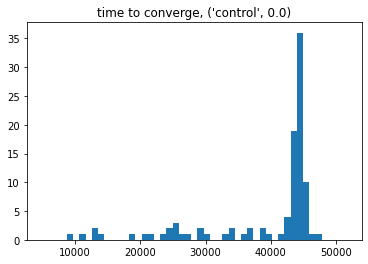

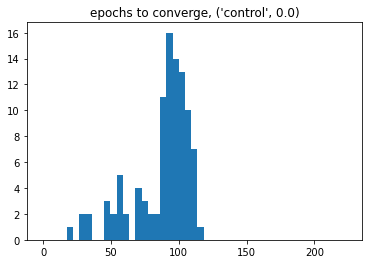

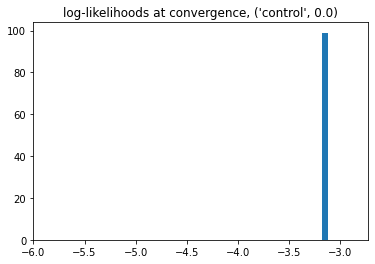

('BFGS', 0.0)


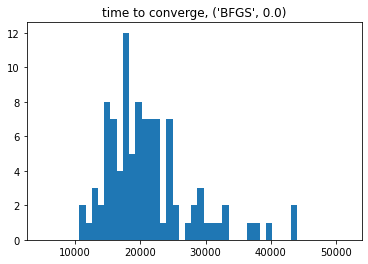

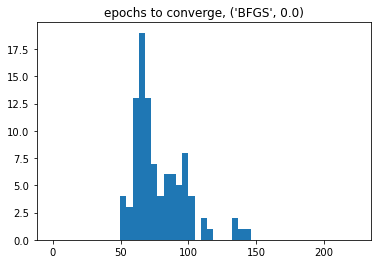

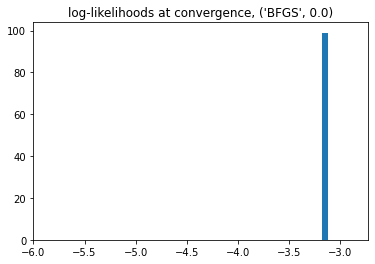

('SAGA', 0.0)


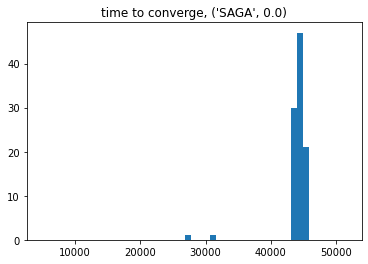

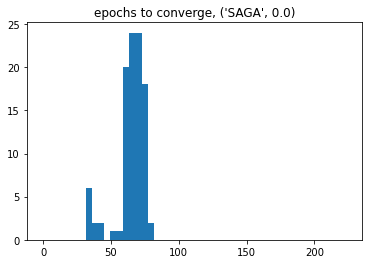

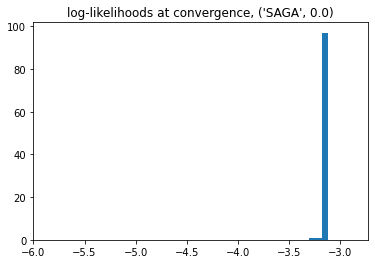

('SAGA', 0.5)


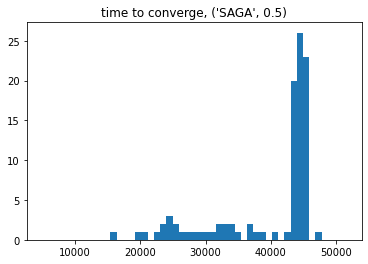

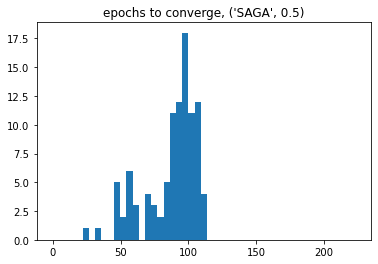

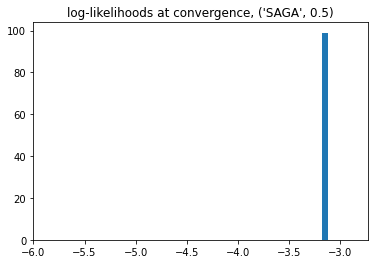

('SAGA', 1.0)


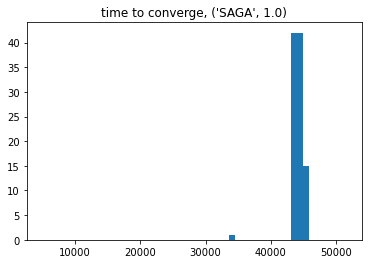

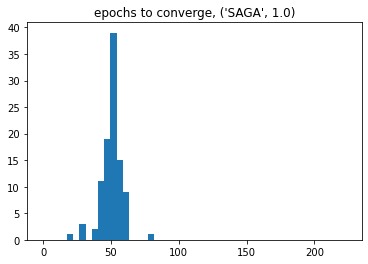

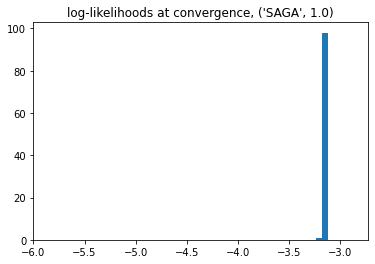

('SVRG', 0.0)


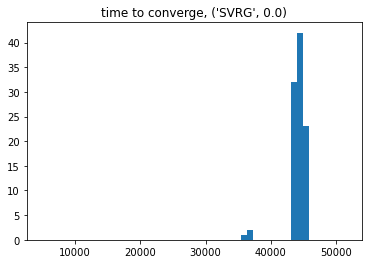

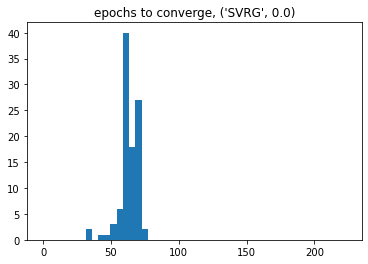

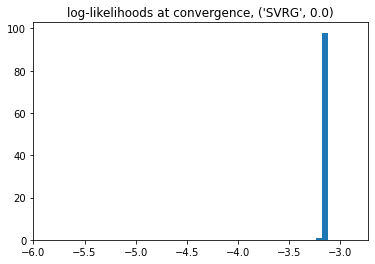

('SVRG', 0.5)


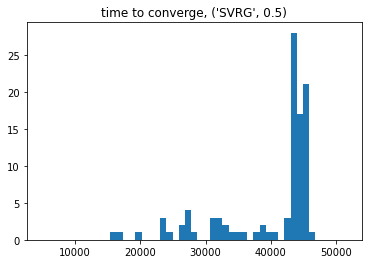

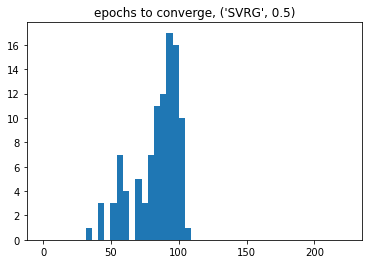

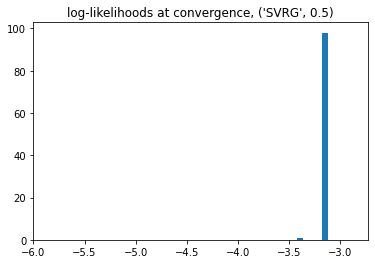

('SVRG', 1.0)


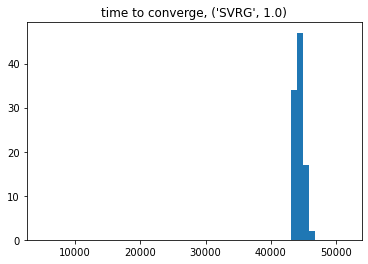

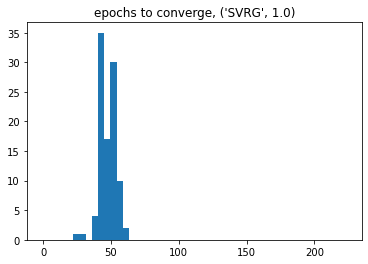

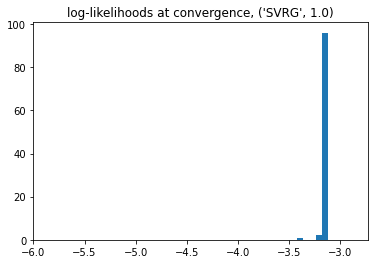

('GD', 0.0)


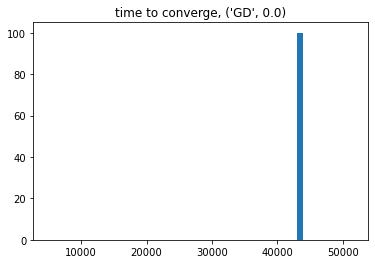

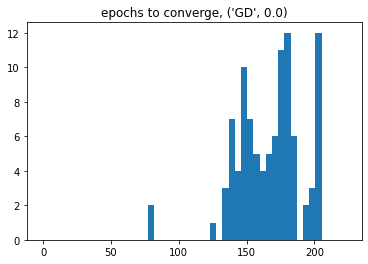

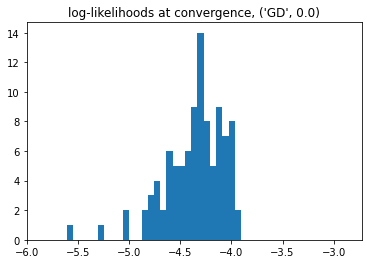

('CG', 0.0)


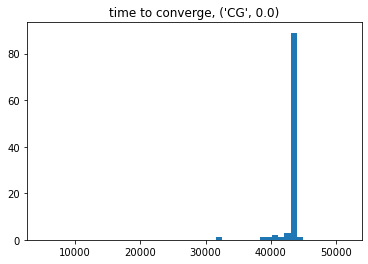

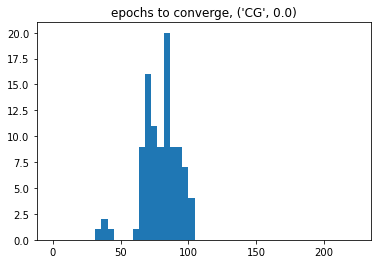

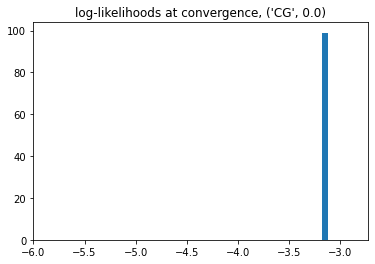

In [10]:
# get min and max time
def get_bins(dictionary,nbins):
    mini = np.infty
    maxi = -np.infty
    for key,values in dictionary.items():
        if len(values) == 0:
            continue
        if mini > min(values):
            mini = min(values)
        if maxi < max(values):
            maxi = max(values)
    return np.linspace(mini - 0.1*(maxi-mini),maxi + 0.1*(maxi-mini),nbins)

        
for key in optims:
    
    print(key)
    
    if key == "control":
        continue
        
    plt.hist(times_to_converge[key],
             bins=get_bins(times_to_converge,50))
    plt.title("time to converge, %s" % str(key))
    plt.show()
    
    plt.hist(epochs_to_converge[key],
             bins=get_bins(epochs_to_converge,50))
    plt.title("epochs to converge, %s" % str(key))
    plt.show()
    
    plt.hist(lls[key],
             bins=get_bins(lls,50))
    plt.title("log-likelihoods at convergence, %s" % str(key))
    plt.show()

# Plot Results

In [11]:
methods = ["BFGS","CG","GD","SAGA","SVRG"]
cmap = cm.get_cmap('tab10')

linestyles = {("BFGS",0.0):("black","-"),
              ("CG",0.0)  :("black","--"),
              ("GD",0.0)  :("black",":"),
              ("SAGA",0.0):(cmap(0),"-"),
              ("SAGA",0.5):(cmap(0),"--"),
              ("SAGA",1.0):(cmap(0),":"),
              ("SVRG",0.0):(cmap(1),"-"),
              ("SVRG",0.5):(cmap(1),"--"),
              ("SVRG",1.0):(cmap(1),":")}

ll_star = optims[("control",0.0)].log_like_trace[-1]
theta_star = optims[("control",0.0)].theta
eta_star = optims[("control",0.0)].eta
eta0_star = optims[("control",0.0)].eta0

for key in optims:
    
    print(key)
    print(optims[key].log_like_trace[-1])
    
    if ll_star < optims[key].log_like_trace[-1]:
        
        print("control model has lower likelihood than a test model")
        
        update_ll = True
        for feature,k0,k1 in product(optims[key].features,range(optims[key].K[0]),range(optims[key].K[1])):
            if optims[key].theta[k0][feature]['log_sig'][k1] < -5:
                print("...but the test model has ~0 varaince. continuing...")
                update_ll = False
                break
                        
        if update_ll:
            ll_star = optims[key].log_like_trace[-1]
            Gamma_star = np.exp(optims[key].log_Gamma)
            theta_star = optims[key].theta
            eta_star = optims[key].eta
            eta0_star = optims[key].eta0

('control', 0.0)
-3.1220091201163034
('BFGS', 0.0)
-3.121637392457534
control model has lower likelihood than a test model
('SAGA', 0.0)
-3.1225779508816522
('SAGA', 0.5)
-3.122088600881171
('SAGA', 1.0)
-3.126098549977129
('SVRG', 0.0)
-3.12258583591072
('SVRG', 0.5)
-3.1237360397075866
('SVRG', 1.0)
-3.1272369087722933
('GD', 0.0)
-3.9477905837354674
('CG', 0.0)
-3.1251890713121275


In [12]:
def plot_ll(optims,x_time=False,xlims=None,ylims=None):
    
    legend = []
    plt.figure(figsize=(8,6))
    
    for method in methods:
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                lcol = linestyles[(method,partial_E)][0]
                ltyp = linestyles[(method,partial_E)][1]
                if x_time:
                    plt.plot(optim.time_trace,ll_star-optim.log_like_trace,
                             color=lcol,linestyle=ltyp)
                else:
                    plt.plot(optim.epoch_trace,ll_star-optim.log_like_trace,
                             color=lcol,linestyle=ltyp)   
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$\ell(\theta^*, \eta^*) - \ell(\theta, \eta)$")
    plt.yscale("log")
    plt.legend(legend,loc='upper center', bbox_to_anchor=(0.5, 1.2),
               ncol=3)
    #plt.legend(legend)
    
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig(plot_folder + "/log-like_v_time_K-%d-%d.png"%(K[0],K[1]),dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig(plot_folder + "/log-like_v_epoch_K-%d-%d.png"%(K[0],K[1]),dpi=500)
        
    if not xlims is None:
        plt.xlim(xlims)
    if not ylims is None:
        plt.ylim(ylims)
        
    plt.show()
                
    return

In [13]:
def find_perm(optim,eta_star,theta_star):
    
    # get the coarse-scale permutation of states
    cost_matrix = np.zeros((optim.K[0],optim.K[0]))
    
    # get the coarse-scale permutation
    Gamma_coarse_star = np.exp(eta_2_log_Gamma(eta_star)[0])
    Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1])

    Gamma_coarse_optm = np.exp(eta_2_log_Gamma(optim.eta)[0])
    Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta)[1])

    # get the trace of each fine-scale ptm
    for k0_star in range(optim.K[0]):
        square_dists = np.zeros(optim.K[0])
        for k0_optm in range(optim.K[0]):
            square_dists[k0_optm] += (Gamma_coarse_star[k0_star,k0_star] - \
                                      Gamma_coarse_optm[k0_optm,k0_optm])**2 
            square_dists[k0_optm] += (np.trace(Gamma_fine_star[k0_star]) - \
                                      np.trace(Gamma_fine_optm[k0_optm]))**2 

        cost_matrix[k0_star] = square_dists

    star_states_coarse, optim_states_coarse = linear_sum_assignment(cost_matrix)

    # get the fine-scale permutations
    star_states_fine = [None for _ in range(optim.K[0])]
    optim_states_fine = [None for _ in range(optim.K[0])]

    for k0_star in range(optim.K[0]):
        k0_optm = optim_states_coarse[k0_star]

        # get the fine-scale permutation of states
        cost_matrix = np.zeros((optim.K[1],optim.K[1]))

        # get the fine-scale permutation
        Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1][k0_star])
        Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta)[1][k0_optm])

        for k1_star in range(optim.K[1]):
            square_dists = np.zeros(optim.K[1])
            for k1_optm in range(optim.K[1]):
                for feature in optim.features:
                    square_dists[k1_optm] += (theta_star[k0_star][feature]['mu'][k1_star] - \
                                              optim.theta[k0_optm][feature]['mu'][k1_optm])**2 
                    square_dists[k1_optm] += (np.exp(theta_star[k0_star][feature]['log_sig'][k1_star]) - \
                                              np.exp(optim.theta[k0_optm][feature]['log_sig'][k1_optm]))**2 
                square_dists[k1_optm] += (Gamma_fine_star[k1_star,k1_star] - \
                                          Gamma_fine_optm[k1_optm,k1_optm])**2 

            cost_matrix[k1_star] = square_dists

        star_states_fine[k0_star], optim_states_fine[k0_optm] = linear_sum_assignment(cost_matrix)

    return optim_states_coarse,optim_states_fine

In [14]:
def find_distances(optim,theta_star,eta_star,eta0_star):

    # get permutation
    optim_states_coarse,optim_states_fine = find_perm(optim,eta_star,theta_star)
    
    # now get distances
    square_dists = np.zeros(len(optim.epoch_trace))

    Gamma_coarse_star = np.exp(eta_2_log_Gamma(eta_star)[0])
    Gamma_fine_star = np.exp(eta_2_log_Gamma(eta_star)[1])

    delta_coarse_star = np.exp(eta0_2_log_delta(eta0_star)[0])
    delta_fine_star = np.exp(eta0_2_log_delta(eta0_star)[1])

    for i in range(len(optim.epoch_trace)):

        # add theta
        for k0_star in range(optim.K[0]):
            k0_optm = optim_states_coarse[k0_star]
            for k1_star in range(optim.K[1]):
                k1_optm = optim_states_fine[k0_optm][k1_star]
                for feature in optim.features:
                    square_dists[i] += (theta_star[k0_star][feature]['mu'][k1_star] - \
                                        optim.theta_trace[i][k0_optm][feature]['mu'][k1_optm])**2 
                    square_dists[i] += (np.exp(theta_star[k0_star][feature]['log_sig'][k1_star]) - \
                                        np.exp(optim.theta_trace[i][k0_optm][feature]['log_sig'][k1_optm]))**2 

        
        # get Gamma and delta
        Gamma_coarse_optm = np.exp(eta_2_log_Gamma(optim.eta_trace[i])[0])
        Gamma_fine_optm = np.exp(eta_2_log_Gamma(optim.eta_trace[i])[1])

        delta_coarse_optm = np.exp(eta0_2_log_delta(optim.eta0_trace[i])[0])
        delta_fine_optm = np.exp(eta0_2_log_delta(optim.eta0_trace[i])[1])

        # add coarse Gamma and delta
        for i_star in range(optim.K[0]):
            i_optm = optim_states_coarse[i_star]

            for j_star in range(optim.K[0]):
                j_optm = optim_states_coarse[j_star]

                square_dists[i] += (Gamma_coarse_star[i_star,j_star] - \
                                    Gamma_coarse_optm[i_optm,j_optm])**2

            # BUG IN CODE NEED TO FIX :(
            #square_dists[i] += (delta_coarse_star[i_star] - \
            #                    delta_coarse_optm[i_optm])**2
            

        # add fine Gamma and delta
        for k0_star in range(optim.K[0]):
            k0_optm = optim_states_coarse[k0_star]

            for i_star in range(optim.K[1]):
                i_optm = optim_states_fine[k0_optm][i_star]

                for j_star in range(optim.K[1]):
                    j_optm = optim_states_fine[k0_optm][j_star]

                    square_dists[i] += (Gamma_fine_star[k0_star][i_star,j_star] - \
                                        Gamma_fine_optm[k0_optm][i_optm,j_optm])**2

                # BUG IN CODE NEED TO FIX :(
                #square_dists[i] += (delta_fine_star[k0_star][i_star] - \
                #delta_fine_optm[k0_optm][i_optm])**2
                
    return square_dists

In [15]:
def plot_dists(optims,theta_star,eta_star,eta0_star,x_time=False,xlims=None,ylims=None):
    
    legend = []
    plt.figure(figsize=(8,6))
    
    for method in methods:
        
        for partial_E in [0,0.5,1]:
            
            PE = (partial_E == 0.5) or (partial_E == 1)
            M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
            
            if (method,partial_E) in optims:
                
                optim = optims[(method,partial_E)]
                lcol = linestyles[(method,partial_E)][0]
                ltyp = linestyles[(method,partial_E)][1]
                
                dists = find_distances(optim,theta_star,eta_star,eta0_star)
                
                if x_time:
                    plt.plot(optim.time_trace,dists,
                             color=lcol,linestyle=ltyp)
                else:
                    plt.plot(optim.epoch_trace,dists,
                             color=lcol,linestyle=ltyp)   
                title = method 
                if partial_E:
                    title += ", partial E"
                else:
                    title += ", no partial E"
                title += ", M = %dT" % M
                
                legend.append(title)
                
    plt.ylabel(r"$||(\theta^*, \eta^*) - (\theta, \eta)||^2_2$")
    plt.yscale("log")
    plt.legend(legend,loc='upper center', bbox_to_anchor=(0.5, 1.2),
               ncol=3)
    #plt.legend(legend)
    
    if x_time:
        plt.xlabel("Seconds of Computation")
        plt.savefig(plot_folder + "/dist_v_time_K-%d-%d.png"%(K[0],K[1]),dpi=500)
    else:
        plt.xlabel("Epoch")
        plt.savefig(plot_folder + "/dist_v_epoch_K-%d-%d.png"%(K[0],K[1]),dpi=500)
        
    if not xlims is None:
        plt.xlim(xlims)
    if not ylims is None:
        plt.ylim(ylims)
        
    plt.show()
                
    return

In [16]:
def plot_results(optim,ll_star,method,partial_E,M,features,iters=None):
    
    title = method 
    if partial_E:
        title += ", partial E-step"
    else:
        title += ", no partial E"
    title += ", M = %dT" % M
    
    if iters is None:
        iters=len(optim.theta_trace)
        
    x = optim.epoch_trace
    
    # plot log of gradient of log-likelihood
    plt.plot(optim.epoch_trace,np.log10(optim.grad_norm_trace))
    plt.axhline(-3, c = 'k', linestyle = "--")
    plt.title(r"$\log_{10}$ of Gradient Norm v Epoch, %s" % title)
    plt.xlabel("Epoch (k)")
    plt.ylabel(r"$\log ||\widehat \nabla_\theta F^{(k,m)} + \widehat \nabla_\eta G^{(k,m)}||$")
    plt.savefig(plot_folder + "/grad-hat-ll-%s-%s-K-%d-%d.png"%(method,partial_E,K[0],K[1]),dpi=300)
    plt.show()
    
    for feature in features:
        
        # plot means
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][k0][feature]['mu'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\mu^{(%d,%d)}$"%(k0+1,k1+1))

        plt.title(feature + r" $\mu$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig(plot_folder + "/mu-%s-%s-%d-K-%d-%d.png"%(method,partial_E,M,K[0],K[1]),dpi=500)
        plt.show()

        # plot log(sigma)
        legend = []
        for k0 in range(optim.K[0]):
            for k1 in range(optim.K[1]):
                plt.plot(x,[optim.theta_trace[t][k0][feature]['log_sig'][k1] for t in range(len(optim.theta_trace))])
                legend.append(r"$\log\left(\sigma^{(%d,%d)}\right)$"%(k0+1,k1+1))

        plt.title(feature + r" $\log\left(\sigma\right)$ v Epoch, %s" % title)
        plt.xlabel("Epoch")
        plt.legend(legend)
        plt.savefig(plot_folder + "/log-sig-%s-%s-%d-K-%d-%d.png"%(method,partial_E,M,K[0],K[1]),dpi=500)
        plt.show()
    
    # plot eta_coarse
    legend = []
    for k in range(optim.K[0]):
        for l in range(optim.K[0]):
            if k != l:
                plt.plot(x,[optim.eta_trace[i][0][k,l] for i in range(len(optim.eta_trace))])
                legend.append(r"$\eta^{(%d,%d)}$" % (k+1,l+1))
    plt.title(r"$\eta$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig(plot_folder + "/eta-%s-%s-%d-K-%d-%d.png"%(method,partial_E,M,K[0],K[1]),dpi=500)
    plt.show()
    
    # plot eta_fine
    legend = []
    for k0 in range(optim.K[0]):
        for i in range(optim.K[1]):
            for j in range(optim.K[1]):
                if i != j:
                    plt.plot(x,[optim.eta_trace[t][1][k0][i,j] for t in range(len(optim.eta_trace))])
                    legend.append(r"$\eta_%d^{*(%d,%d)}$" % (k0,i+1,j+1))
    plt.title(r"$\eta^*$ v Epoch, %s" % title)
    plt.xlabel("Epoch")
    plt.legend(legend)
    plt.savefig(plot_folder + "/eta-fine-%s-%s-%d-K-%d-%d.png"%(method,partial_E,M,K[0],K[1]),dpi=500)
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()

In [17]:
if not os.path.isdir(plot_folder):
    os.mkdir(plot_folder)

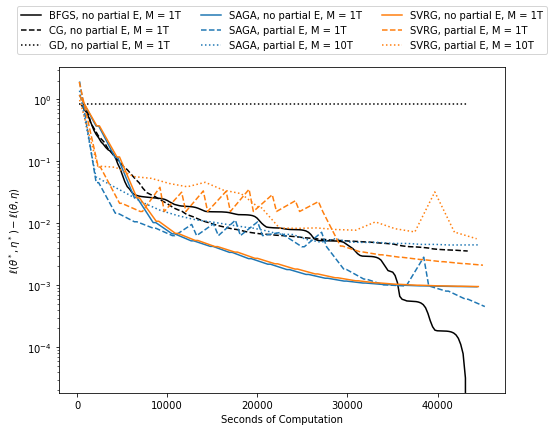

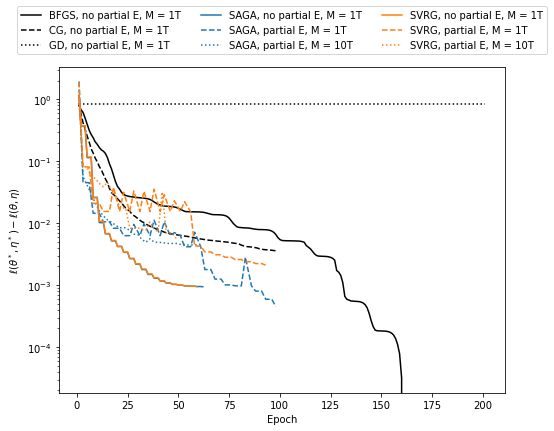

In [18]:
plot_ll(optims,x_time=True)#,xlims=[0,3600],ylims=[1e-2,1e1])
plot_ll(optims,x_time=False)#,xlims=[0,100],ylims=[1e-2,1e1])

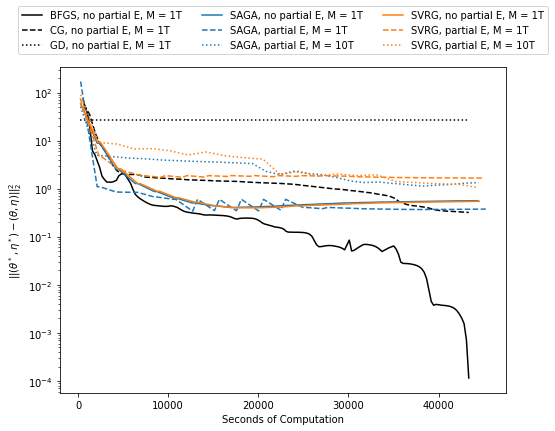

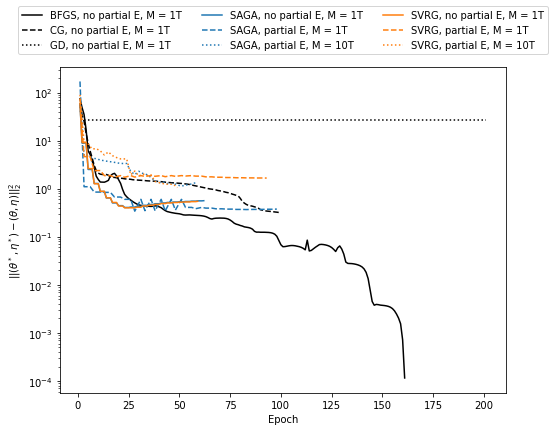

In [19]:
plot_dists(optims,theta_star,eta_star,eta0_star,x_time=True)
plot_dists(optims,theta_star,eta_star,eta0_star,x_time=False)

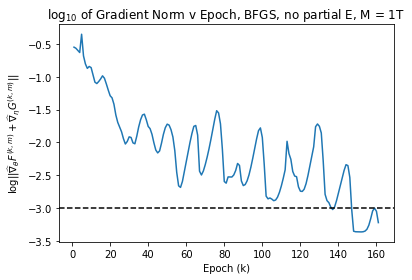

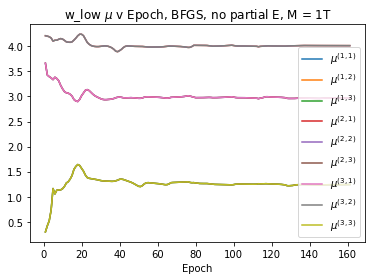

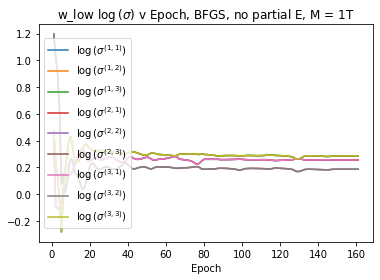

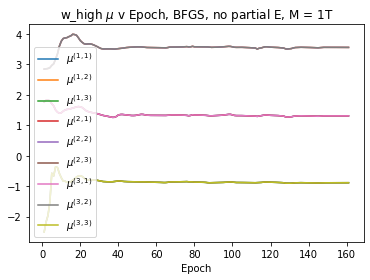

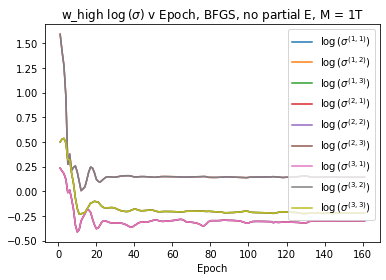

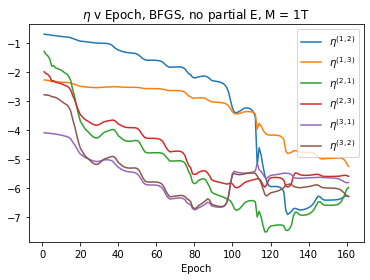

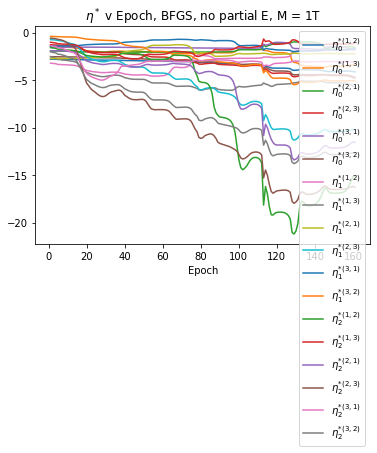

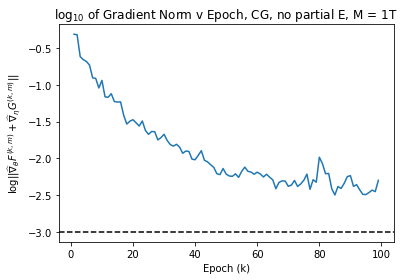

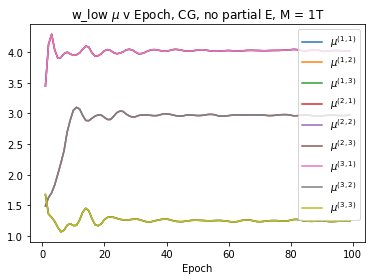

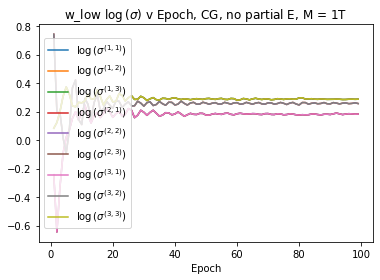

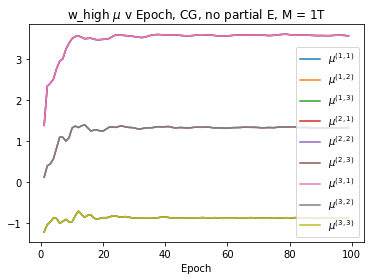

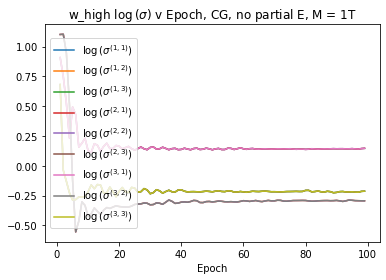

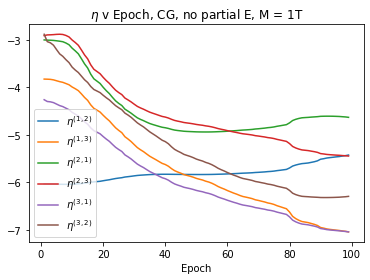

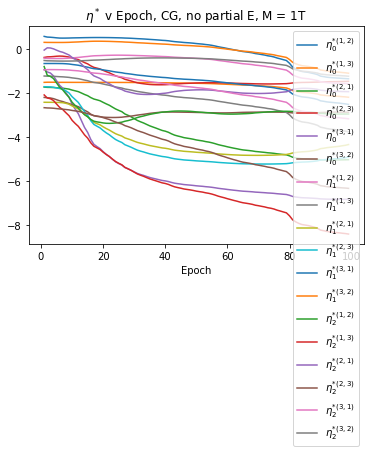

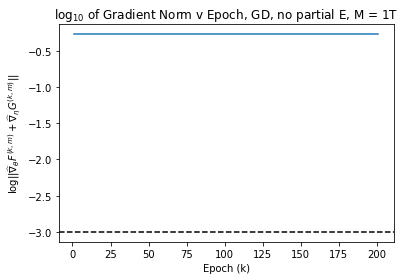

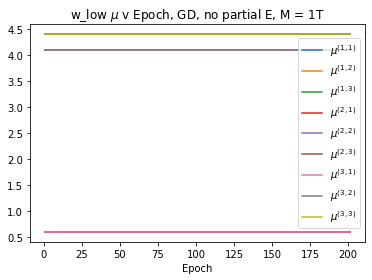

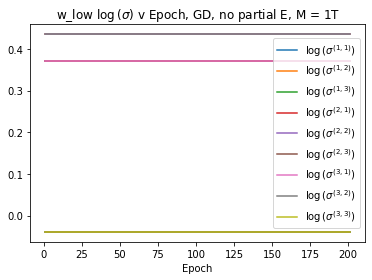

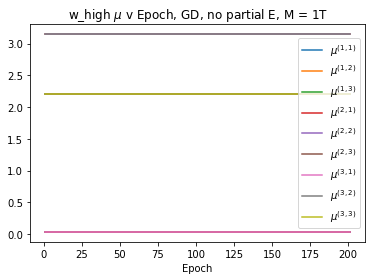

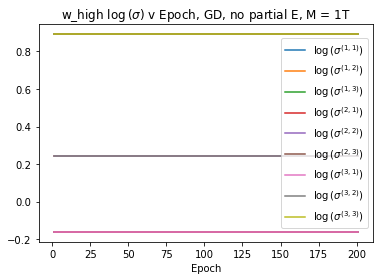

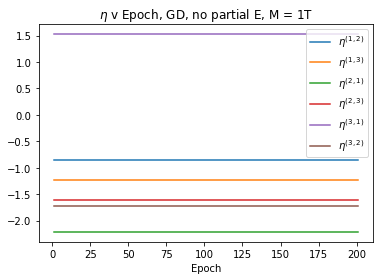

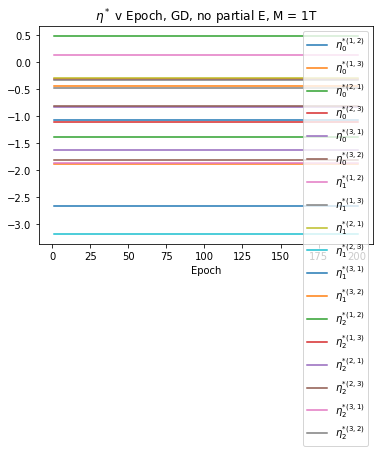

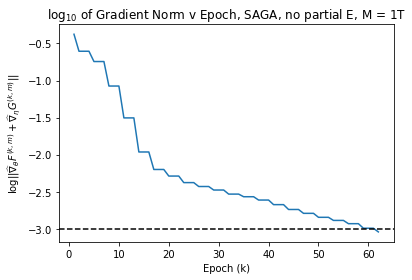

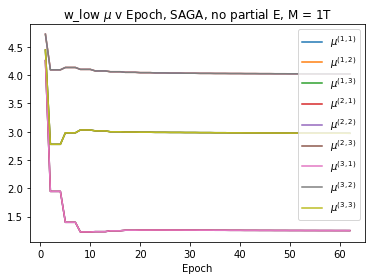

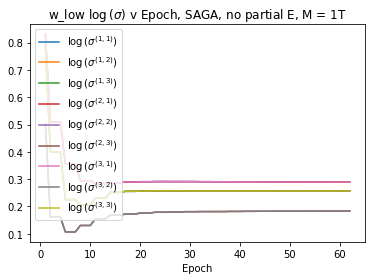

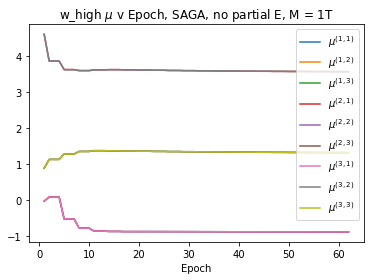

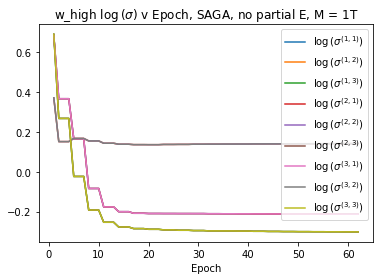

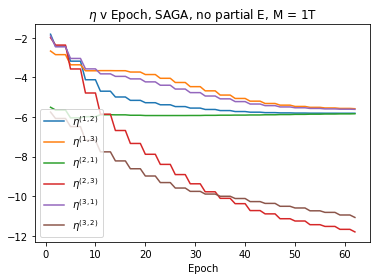

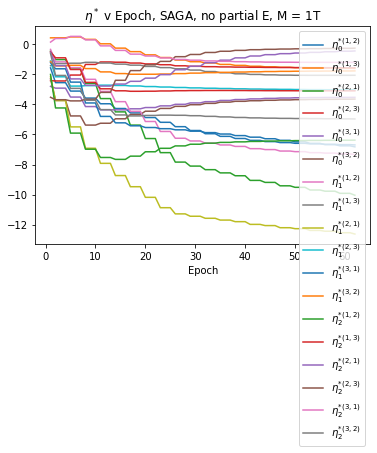

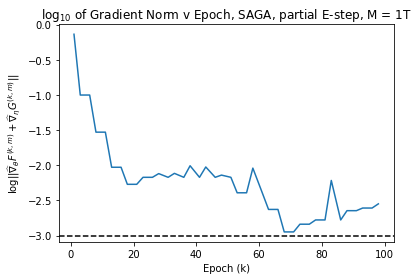

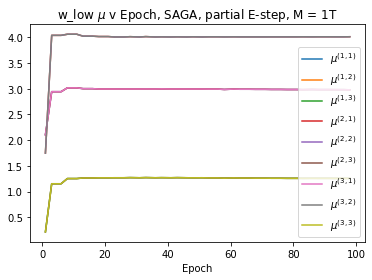

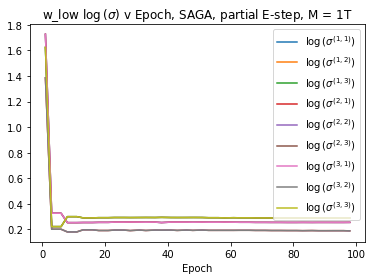

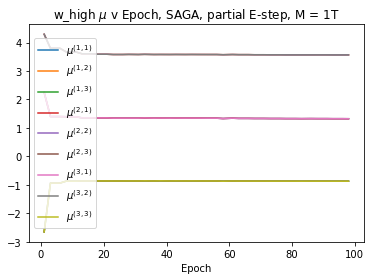

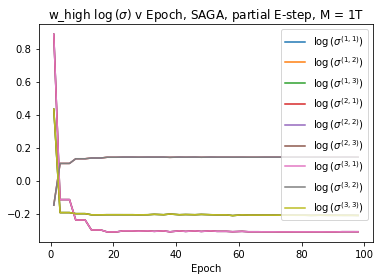

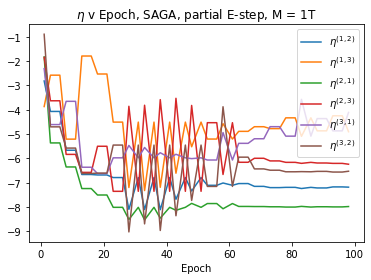

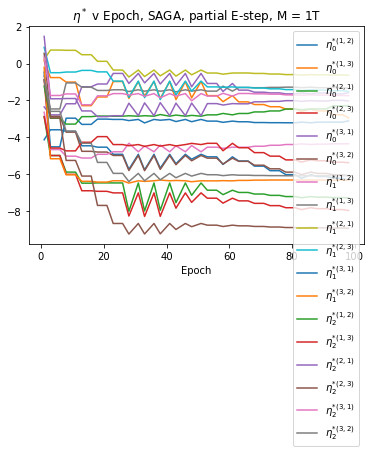

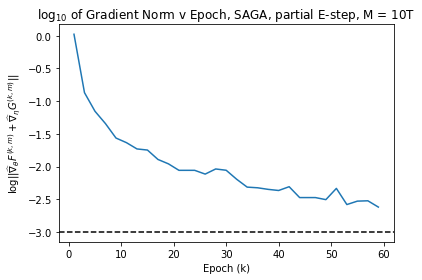

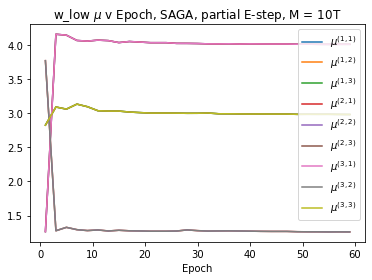

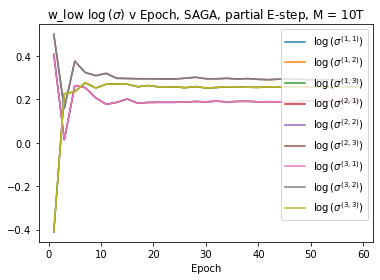

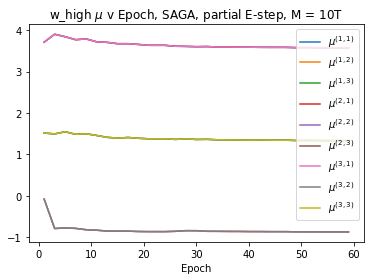

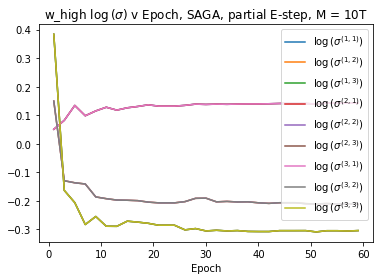

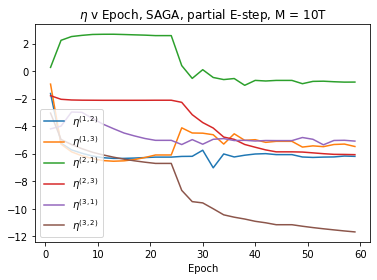

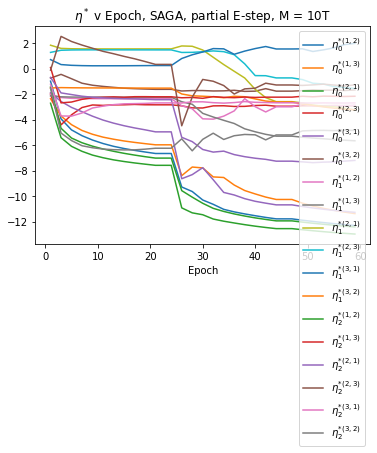

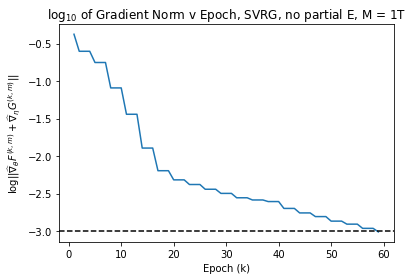

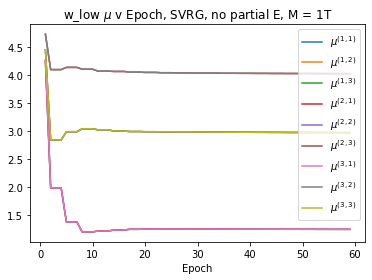

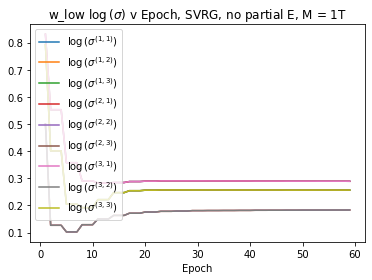

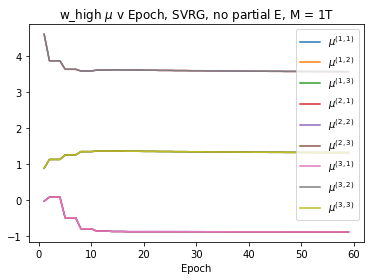

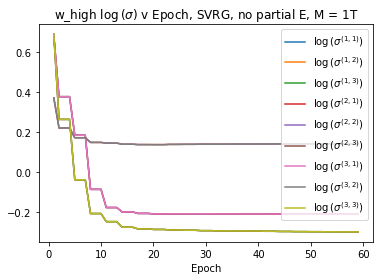

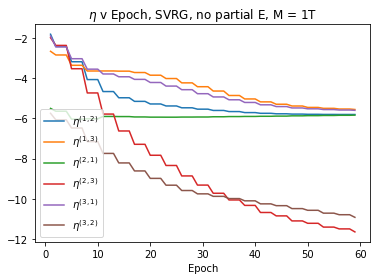

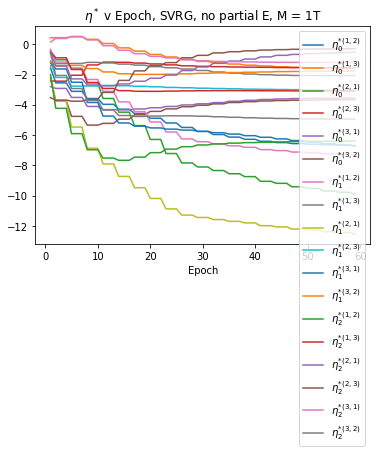

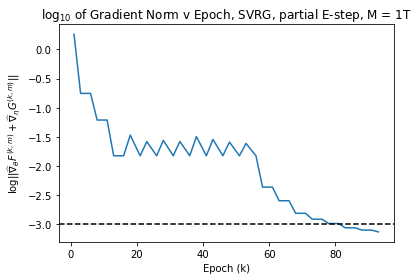

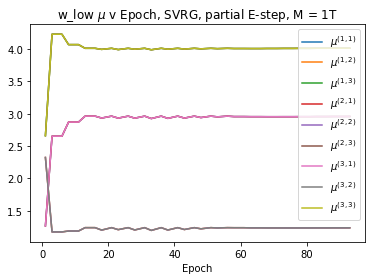

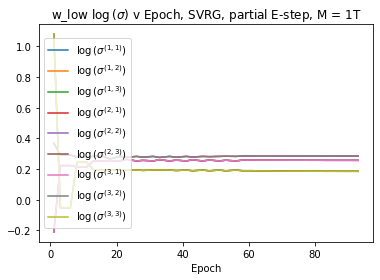

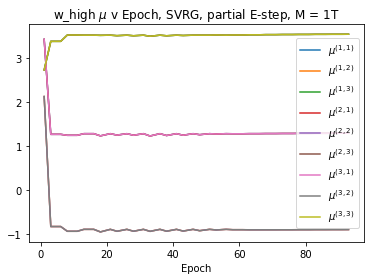

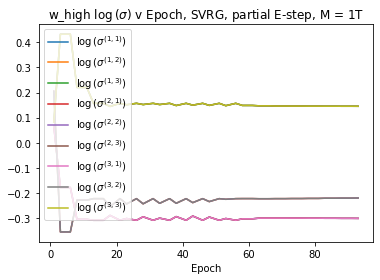

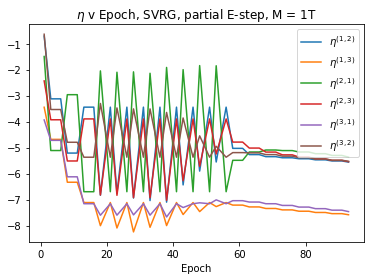

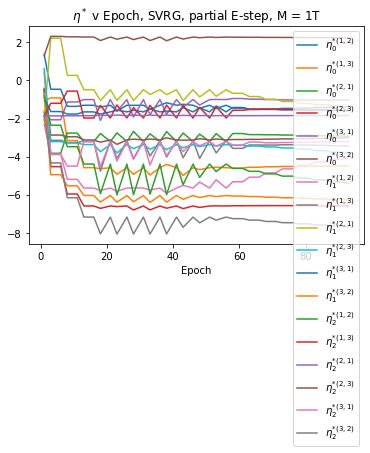

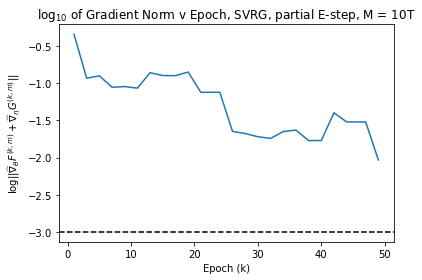

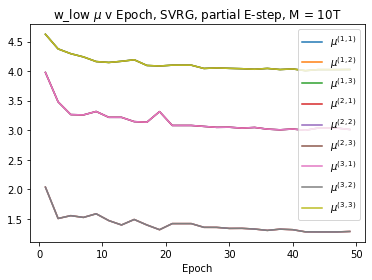

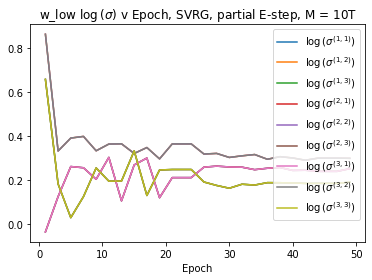

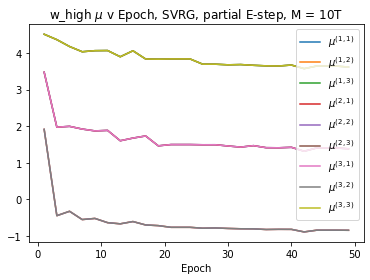

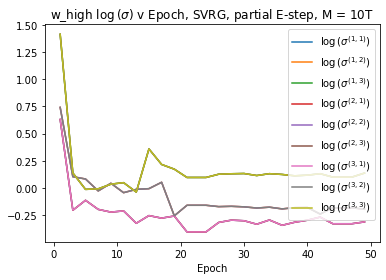

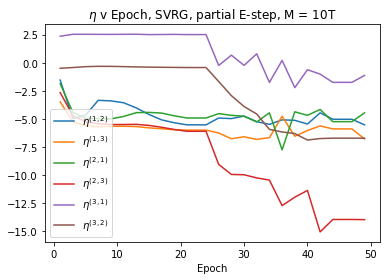

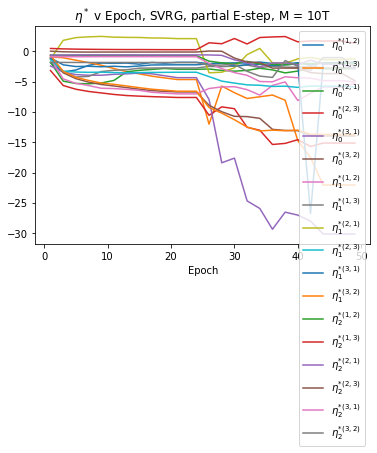

In [20]:
for method in methods:#["EM","SGD","SAG","SVRG","SAGA"]:
    for partial_E in [0,0.5,1]:
        PE = (partial_E == 0.5) or (partial_E == 1)
        M = int(partial_E == 0) + int(partial_E == 0.5) + 10*(partial_E == 1)
        if (method,partial_E) in optims:
            plot_results(optims[(method,partial_E)],
                         ll_star,method,PE,M,optims[("control",0.0)].features)